<h1>Pronóstico Mortero Seco</h1>

In [1]:
#Importar librerias
import numpy as np
import pandas as pd 
import datetime
from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import MonthBegin

from io import BytesIO
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

Using TensorFlow backend.
/Users/jsdelgadoc/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jsdelgadoc/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jsdelgadoc/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jsdelgadoc/opt/anacond

In [2]:
def plot_time_series(dates, values, title, x_label, y_label):
    """
    dates: must be a datetime series for the x axis
    values: the y axis values to plot
    title: string that goes above the plot
    x_label: string that goes on the x-axis
    y_label: string that goes on the y-axis
    """

    years_locator = mdates.YearLocator()
    months_locator = mdates.MonthLocator()
    years_format = mdates.DateFormatter('%Y')
    days_locator = mdates.DayLocator()
    days_format = mdates.DateFormatter('%d')

    sns.set_style('ticks')
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 6)

    ax.ticklabel_format(axis='y', style='plain')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.xaxis.set_major_locator(years_locator)
    ax.xaxis.set_major_formatter(years_format)
    ax.xaxis.set_minor_locator(months_locator)
    

    sns.lineplot(x=dates, y=values, ci=None)

    rotation = 45
    plt.setp(ax.get_xticklabels(), rotation=rotation)
    plt.xlabel(x_label, fontsize='16')
    plt.ylabel(y_label, fontsize='16')
    plt.title(title, fontsize='18')

    plt.show()
    
def plot_comparative_time_series(dates, values,values2, title, x_label, y_label, values_label, values2_label):
    """
    dates: must be a datetime series for the x axis
    values: the y axis values to plot
    title: string that goes above the plot
    x_label: string that goes on the x-axis
    y_label: string that goes on the y-axis
    """

    years_locator = mdates.YearLocator()
    months_locator = mdates.MonthLocator()
    days_locator = mdates.DayLocator()
    days_format = mdates.DateFormatter('%d')



    sns.set_style('ticks')
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 6)

    ax.ticklabel_format(axis='y', style='plain')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.xaxis.set_major_locator(days_locator)
    ax.xaxis.set_major_formatter(days_format)
    ax.xaxis.set_minor_locator(months_locator)

    sns.lineplot(x=dates, y=values, ci=None,  label = values_label)
    sns.lineplot(x=dates, y=values2, ci=None, label = values2_label)

    rotation = 45
    plt.setp(ax.get_xticklabels(), rotation=rotation)
    plt.xlabel(x_label, fontsize='16')
    plt.ylabel(y_label, fontsize='16')
    plt.title(title, fontsize='18')
    plt.legend()

    plt.show()

<h2>Análisis exploratorio de los datos</h2>

In [3]:
#Dataset del informe de ventas
dataset = pd.read_excel("../datos/Base Acumulada.xlsx")
dataset['year_month']=dataset["Fecha Facturación"].dt.to_period('M')
df = dataset[ (dataset['Nombre Material']!="SERVICIO FLETE MORTERO SECO") & (dataset['Nombre Material']!="Sobre Cargo Mortero") & (dataset['Nombre Material']!="Servicio de Descargue Mortero") & (dataset['Nombre Material']!="CEMEX EN SU BODEGA MORTERO") & (dataset['Sum of Cantidad Material'] > 0)]

In [4]:
#Dataset calendario logistico
calendario = pd.read_excel("../datos/DiasHabilesFuente.xlsx")
calendario['Fecha de entrega'] = pd.to_datetime(calendario['Fecha de entrega'])
calendario = calendario[ calendario['Fecha de entrega'] < '2021-05-01']

Text(0.5, 1.0, '¿Cual es el producto que más demanda tiene?')

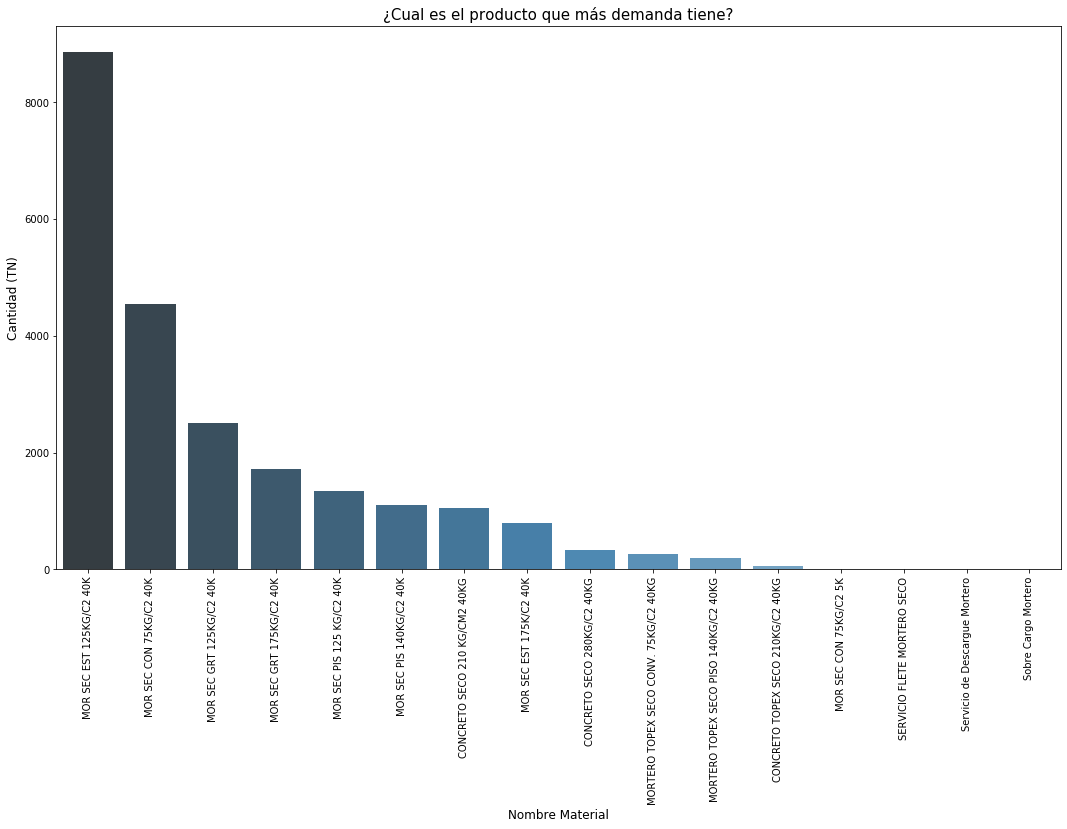

In [5]:
dataset['Sum of Cantidad Material'] = dataset['Sum of Cantidad Material'].astype(float)
agg_material = dataset[dataset['Fecha Facturación'] >= '2021-01-01'].groupby(['Nombre Material'])['Sum of Cantidad Material'].agg(['sum']).reset_index()
plt.figure(figsize=(18,10))
fig1 = sns.barplot(x="Nombre Material", y="sum", data = agg_material, order=agg_material.sort_values('sum', ascending=False)['Nombre Material'], palette="Blues_d")
fig1.set_xticklabels(fig1.get_xticklabels() , rotation=90);
plt.ylabel("Cantidad (TN)", size=12)
plt.xlabel("Nombre Material", size=12)
plt.title("¿Cual es el producto que más demanda tiene?", size=15)

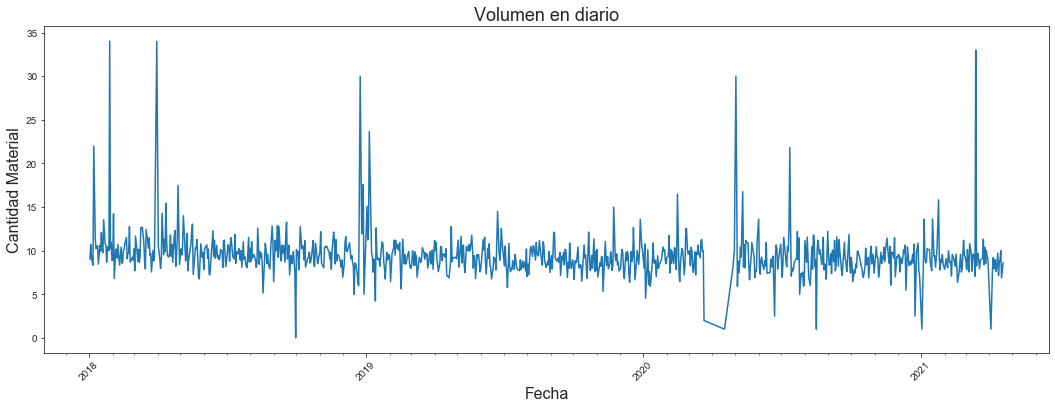

In [127]:
plot_time_series(df['Fecha Facturación'], df['Sum of Cantidad Material'] ,'Volumen en diario', 'Fecha', 'Cantidad Material' )

In [10]:
d = df.groupby(dataset['Fecha Facturación'])['Sum of Cantidad Material'].sum().reset_index()
d = pd.merge(calendario[calendario['Fecha de entrega'] < '2020-12-31']['Fecha de entrega'], d, how='left', left_on=['Fecha de entrega'], right_on='Fecha Facturación').drop(['Fecha Facturación'], axis=1)
d = d.set_index(['Fecha de entrega'])
d = d.asfreq('d')
d['Sum of Cantidad Material'] = d['Sum of Cantidad Material'].fillna(method='bfill')

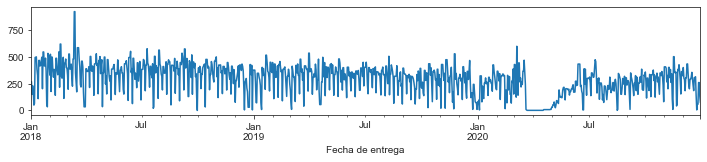

In [11]:
results = seasonal_decompose(d['Sum of Cantidad Material'])
results.observed.plot(figsize=(12,2))

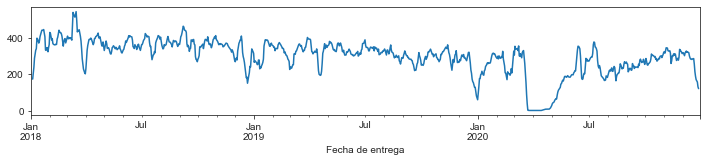

In [12]:
results.trend.plot(figsize=(12,2))

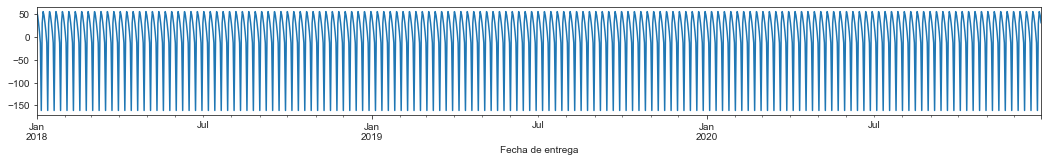

In [13]:
results.seasonal.plot(figsize=(18,2))

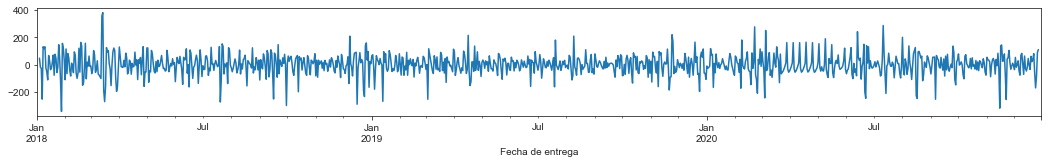

In [14]:
results.resid.plot(figsize=(18,2))

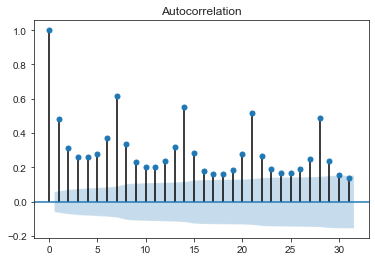

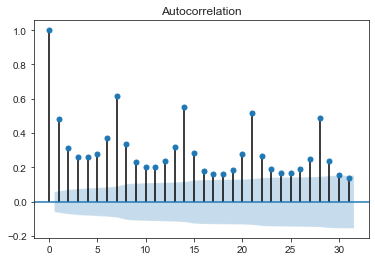

In [319]:
plot_acf(d['Sum of Cantidad Material'])

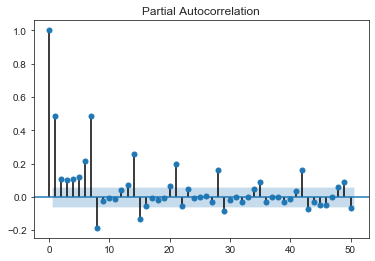

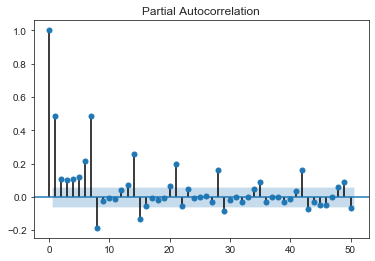

In [320]:
plot_pacf(d['Sum of Cantidad Material'], lags=50)

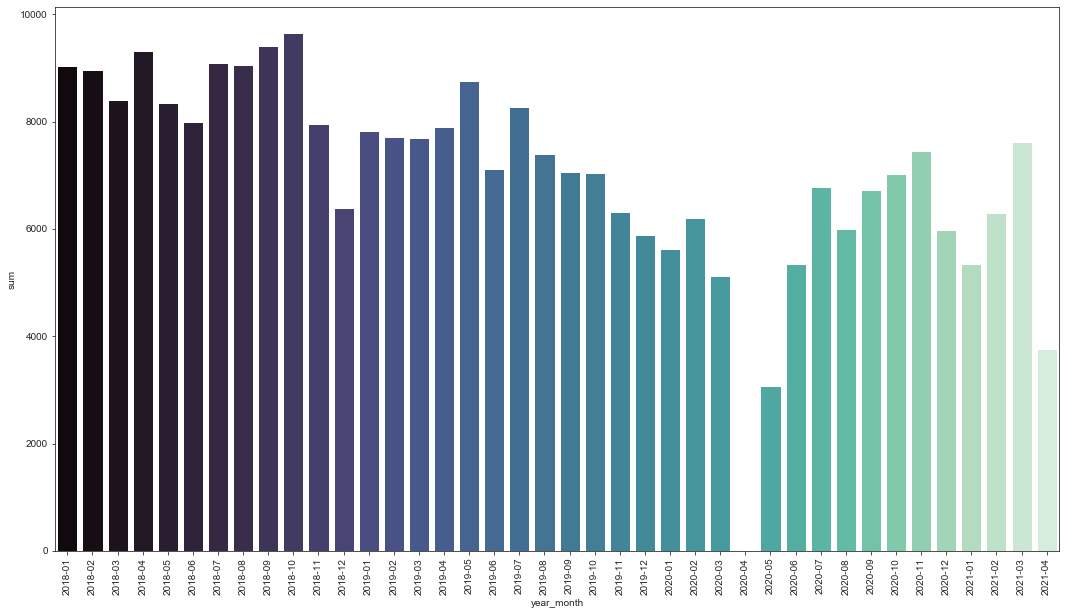

In [254]:
plt.figure(figsize=(18,10))
agg_year_month = df.groupby(['year_month'])['Sum of Cantidad Material'].agg(['sum']).reset_index()
fig1 = sns.barplot(x="year_month", y="sum", data = agg_year_month, palette="mako")
fig1.set_xticklabels(fig1.get_xticklabels() , rotation=90);

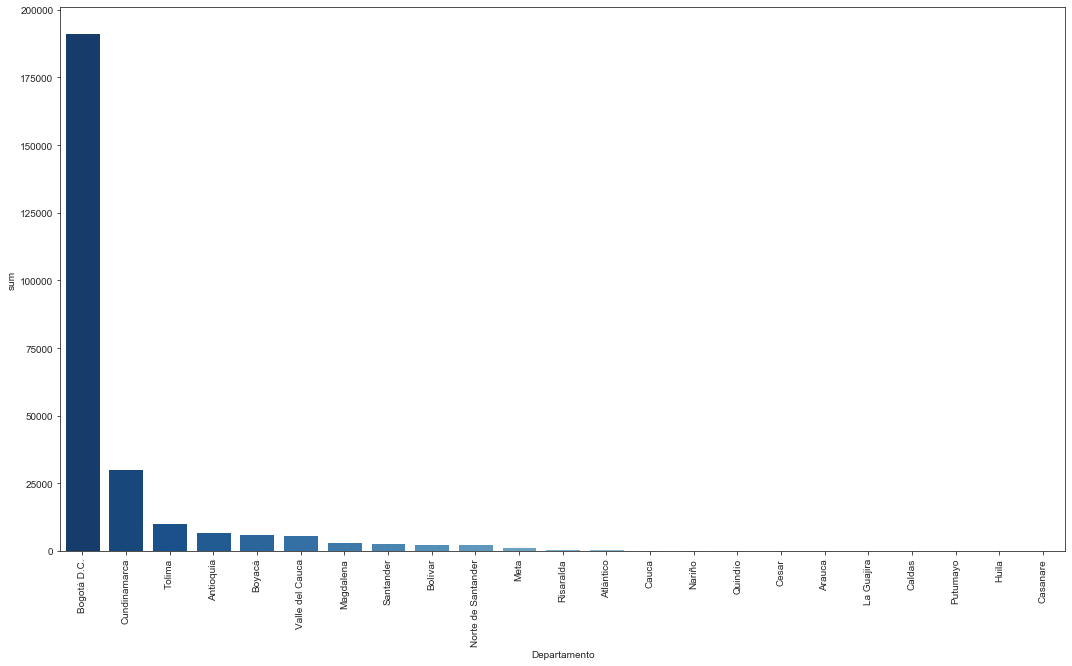

In [322]:
plt.figure(figsize=(18,10))
agg_departamento = df.groupby(['Departamento'])['Sum of Cantidad Material'].agg(['sum']).reset_index()
fig1 = sns.barplot(x="Departamento", y="sum", data = agg_departamento, palette="Blues_r", order = agg_departamento.sort_values('sum', ascending=False)['Departamento'])
fig1.set_xticklabels(fig1.get_xticklabels() , rotation=90);

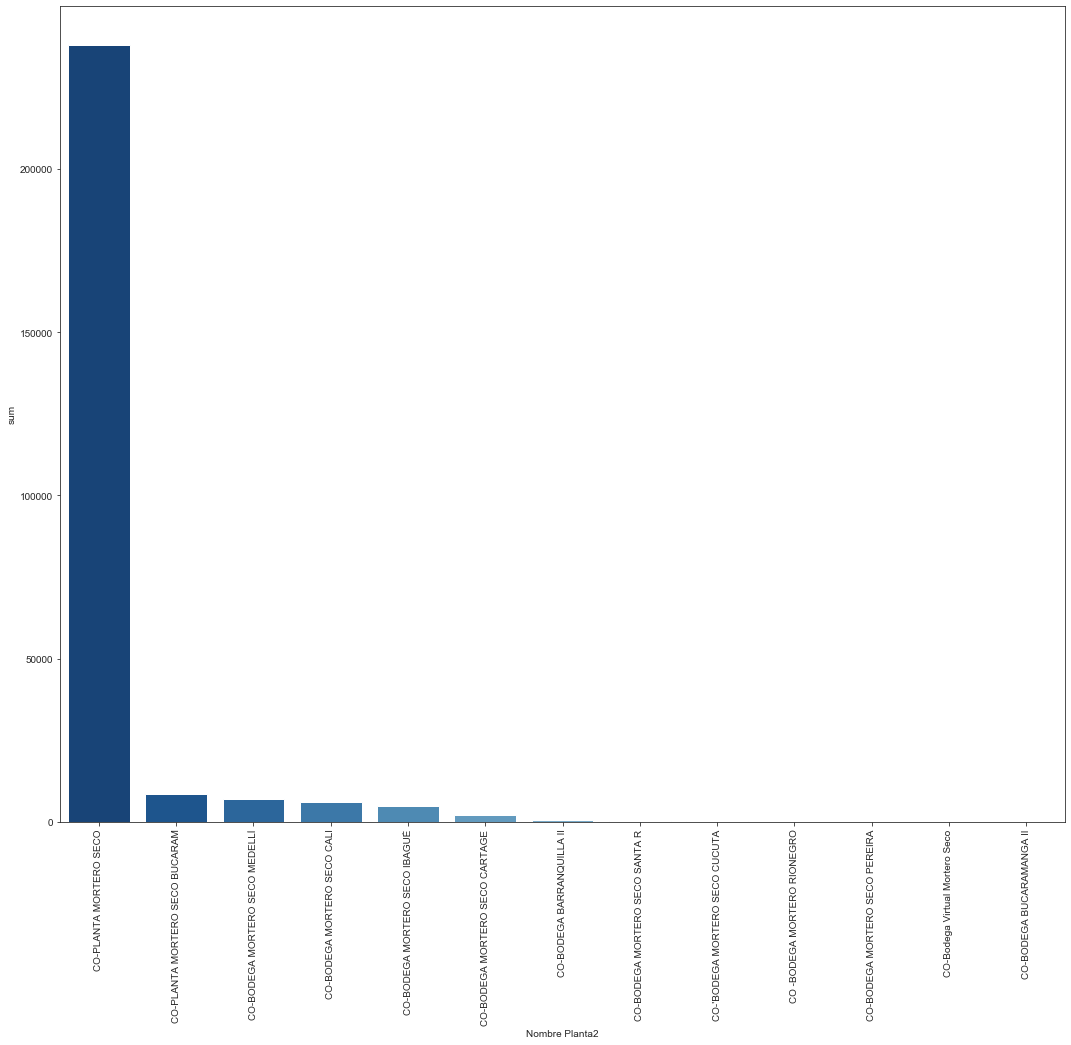

In [323]:
plt.figure(figsize=(18,15))
agg_departamento = df.groupby(['Nombre Planta2'])['Sum of Cantidad Material'].agg(['sum']).reset_index()
fig1 = sns.barplot(x="Nombre Planta2", y="sum", data = agg_departamento, palette="Blues_r", order = agg_departamento.sort_values('sum', ascending=False)['Nombre Planta2'])
fig1.set_xticklabels(fig1.get_xticklabels() , rotation=90);

<h2>Creación de la red neuronal</h2>

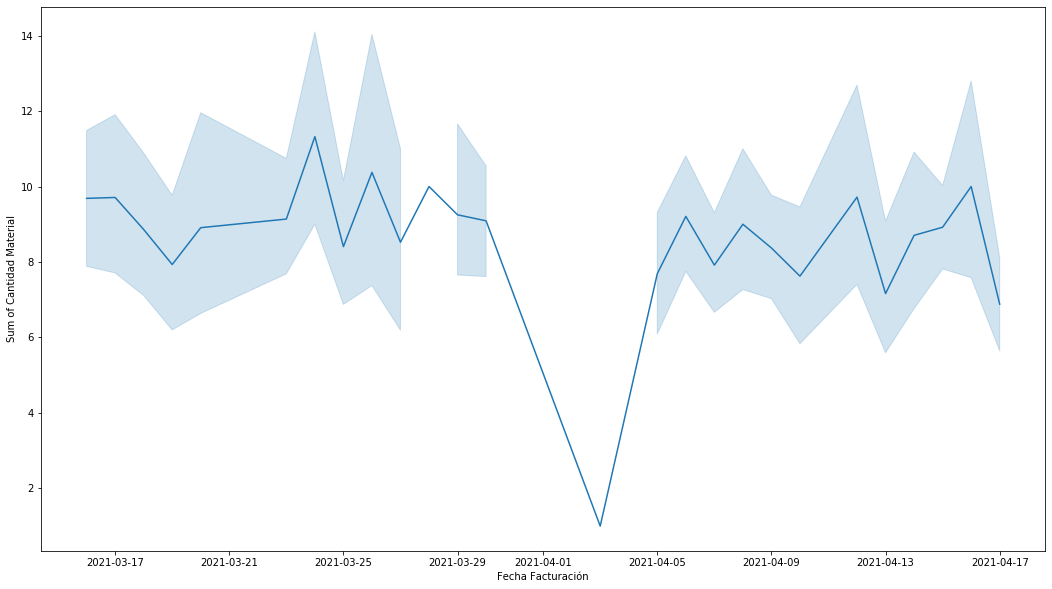

In [12]:
plt.figure(figsize=(18,10))
fig1 = sns.lineplot(x="Fecha Facturación", y="Sum of Cantidad Material", data = df_train[df_train['Fecha Facturación'] > '2021-03-15'] )

In [5]:
#Parametros
fecha_split = '2021-04-18'

#Memoria corto plazo
timesteps = 21

#numero de neuronas
un = 125
#coeficiente de olvido
do = 0.12


In [9]:
#Conjunto para entrenamiento de la red neuronal
#df_train = df[(df['Fecha Facturación'] < fecha_split)]
df_train = df[(df['Fecha Facturación'] < fecha_split)]

#Agrupo la informacion por dia
df_daily = df_train.groupby(['Fecha Facturación'])['Sum of Cantidad Material'].agg('sum').reset_index()

#Agrego informacion del calendario logistico
df_daily = pd.merge(df_daily, calendario[['Fecha de entrega', 'Dia_Semana','Semana_Relativa', 'Semanas_mes', 'Mes', 'Año']], how='inner', left_on='Fecha Facturación', right_on='Fecha de entrega' )
df_daily = df_daily.drop(['Fecha de entrega'], axis=1)

#tomo unicamente el array que me interasa del dataframe 
training_set = df_daily.iloc[:, 1:8].values

#escalado de caracteristicas
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

#defino un array por cada variable predictora
X_train = []
X_train_material = []
X_train_DiaSemana = []
X_train_SemanaRelativa = []
X_train_SemanaMes = []
X_train_Mes = []
X_train_Year = []

y_train = []

for i in range(timesteps, len(training_set)):
    #columna 0 -> Cantidad Material
    X_train_material.append( training_set_scaled[i-timesteps:i, 0])
    
    #columna 1 -> DiaSemana
    X_train_DiaSemana.append( training_set_scaled[i-timesteps:i, 1])
    
    #columna 2 -> SemanaRelativa
    X_train_SemanaRelativa.append( training_set_scaled[i-timesteps:i, 2])

    #columna 3 -> SemanaMes
    X_train_SemanaMes.append( training_set_scaled[i-timesteps:i, 3])
    
    #columna 4 -> Mes
    X_train_Mes.append( training_set_scaled[i-timesteps:i, 4])
    
    #columna 5 -> Year
    X_train_Year.append( training_set_scaled[i-timesteps:i, 5])
    
    y_train.append(training_set_scaled[i, 0])

#se convierten los array en objetos numpy    
X_train_material = np.array( X_train_material)
X_train_DiaSemana =  np.array(X_train_DiaSemana )
X_train_SemanaRelativa = np.array( X_train_SemanaRelativa)
X_train_SemanaMes = np.array(X_train_SemanaMes )
X_train_Mes = np.array(X_train_Mes )
X_train_Year = np.array( X_train_Year)
y_train = np.array(y_train)

#Se agrega una nueva dimension a las variables
X_train_material = np.reshape(X_train_material, (X_train_material.shape[0], X_train_material.shape[1], 1 ))
X_train_DiaSemana = np.reshape(X_train_DiaSemana, (X_train_DiaSemana.shape[0], X_train_DiaSemana.shape[1], 1 ))
X_train_SemanaRelativa = np.reshape(X_train_SemanaRelativa, (X_train_SemanaRelativa.shape[0], X_train_SemanaRelativa.shape[1], 1 ))
X_train_SemanaMes = np.reshape(X_train_SemanaMes, (X_train_SemanaMes.shape[0], X_train_SemanaMes.shape[1], 1 ))
X_train_Mes = np.reshape(X_train_Mes, (X_train_Mes.shape[0], X_train_Mes.shape[1], 1 ))
X_train_Year = np.reshape(X_train_Year, (X_train_Year.shape[0], X_train_Year.shape[1], 1 ))

#se crea el la estructura de datos que se le va a pasar al regresor
X_train = np.append(X_train_material, (X_train_DiaSemana), axis = 2 )
X_train = np.append(X_train, (X_train_SemanaRelativa), axis = 2 )
X_train = np.append(X_train, (X_train_SemanaMes), axis = 2 )
X_train = np.append(X_train, (X_train_Mes), axis = 2 )
X_train = np.append(X_train, (X_train_Year), axis = 2 )

In [265]:
#Construcción de la RNR
#inicializar modelo

regressor = Sequential()

#añadir la primera capa de LSTM y la regularización por Dropout
regressor.add(LSTM(units=un, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
#regressor.add(Dropout(do))
#regressor.add(LSTM(units=un, input_shape=(X_train.shape[1], X_train.shape[2])))

#añadir nueva capa LSTM
regressor.add(LSTM(units=un, return_sequences = True))
regressor.add(Dropout(do))

#añadir penultima capa
regressor.add(LSTM(units=un))
regressor.add(Dropout(do))

"""
#añadir nueva capa LSTM
regressor.add(LSTM(units=un, return_sequences = True))
regressor.add(Dropout(do))

#añadir nueva capa LSTM
regressor.add(LSTM(units=un, return_sequences = True))
regressor.add(Dropout(do))

#añadir nueva capa LSTM
regressor.add(LSTM(units=un, return_sequences = True))
regressor.add(Dropout(do))

#añadir nueva capa LSTM
regressor.add(LSTM(units=un, return_sequences = True))
regressor.add(Dropout(do))

#añadir nueva capa LSTM
regressor.add(LSTM(units=un, return_sequences = True))
regressor.add(Dropout(do))

#añadir nueva capa LSTM
regressor.add(LSTM(units=un, return_sequences = True))
regressor.add(Dropout(do))

#añadir penultima capa
regressor.add(LSTM(units=un))
regressor.add(Dropout(do))
"""
#añadir capa de salida
regressor.add(Dense(units=1))

#compilar la RNR
regressor.compile(optimizer = 'adam', loss='mean_squared_error')    


In [266]:
#ajustar la RNR al conjunto de entrenamiento
regressor.fit(X_train, y_train, epochs=550, batch_size = 512)

Epoch 1/550
916/916 [==============================] - 2s 3ms/step - loss: 0.0648
Epoch 2/550
916/916 [==============================] - 1s 668us/step - loss: 0.0367
Epoch 3/550
916/916 [==============================] - 1s 608us/step - loss: 0.0219
Epoch 4/550
916/916 [==============================] - 1s 609us/step - loss: 0.0241
Epoch 5/550
916/916 [==============================] - 1s 618us/step - loss: 0.0171
Epoch 6/550
916/916 [==============================] - 1s 624us/step - loss: 0.0206
Epoch 7/550
916/916 [==============================] - 1s 612us/step - loss: 0.0157
Epoch 8/550
916/916 [==============================] - 1s 607us/step - loss: 0.0173
Epoch 9/550
916/916 [==============================] - 1s 609us/step - loss: 0.0174
Epoch 10/550
916/916 [==============================] - 1s 609us/step - loss: 0.0156
Epoch 11/550
916/916 [==============================] - 1s 621us/step - loss: 0.0158
Epoch 12/550
916/916 [==============================] - 1s 605us/step - loss

916/916 [==============================] - 1s 718us/step - loss: 0.0131
Epoch 193/550
916/916 [==============================] - 1s 699us/step - loss: 0.0133
Epoch 194/550
916/916 [==============================] - 1s 676us/step - loss: 0.0133
Epoch 195/550
916/916 [==============================] - 1s 675us/step - loss: 0.0134
Epoch 196/550
916/916 [==============================] - 1s 676us/step - loss: 0.0133
Epoch 197/550
916/916 [==============================] - 1s 676us/step - loss: 0.0132
Epoch 198/550
916/916 [==============================] - 1s 704us/step - loss: 0.0131
Epoch 199/550
916/916 [==============================] - 1s 678us/step - loss: 0.0132
Epoch 200/550
916/916 [==============================] - 1s 683us/step - loss: 0.0131
Epoch 201/550
916/916 [==============================] - 1s 699us/step - loss: 0.0131
Epoch 202/550
916/916 [==============================] - 1s 693us/step - loss: 0.0131
Epoch 203/550
916/916 [==============================] - 1s 704us/st

916/916 [==============================] - 1s 690us/step - loss: 0.0097
Epoch 383/550
916/916 [==============================] - 1s 678us/step - loss: 0.0094
Epoch 384/550
916/916 [==============================] - 1s 691us/step - loss: 0.0097
Epoch 385/550
916/916 [==============================] - 1s 691us/step - loss: 0.0098
Epoch 386/550
916/916 [==============================] - 1s 690us/step - loss: 0.0094
Epoch 387/550
916/916 [==============================] - 1s 703us/step - loss: 0.0095
Epoch 388/550
916/916 [==============================] - 1s 708us/step - loss: 0.0093
Epoch 389/550
916/916 [==============================] - 1s 705us/step - loss: 0.0097
Epoch 390/550
916/916 [==============================] - 1s 709us/step - loss: 0.0094
Epoch 391/550
916/916 [==============================] - 1s 704us/step - loss: 0.0093
Epoch 392/550
916/916 [==============================] - 1s 708us/step - loss: 0.0095
Epoch 393/550
916/916 [==============================] - 1s 733us/st

In [10]:
#obtener los datos para el test
#Organizo la informacion del calendario del forecast
fecha_inicio_test = '2021-03-20'
fecha_fin_test = '2021-04-12'
dataset_test = df[ (df['Fecha Facturación'] >= fecha_inicio_test) & (df['Fecha Facturación'] <= fecha_fin_test)]

#Agrupo la informacion por dia
df_cant_real_daily = dataset_test.groupby(['Fecha Facturación'])['Sum of Cantidad Material'].agg('sum').reset_index()

#Agrego informacion del calendario logistico
df_cant_real_daily = pd.merge(df_cant_real_daily, calendario[['Fecha de entrega', 'Dia_Semana','Semana_Relativa', 'Semanas_mes', 'Mes', 'Año']], how='inner', left_on='Fecha Facturación', right_on='Fecha de entrega' )
df_cant_real_daily = df_cant_real_daily.drop(['Fecha de entrega'], axis=1)

#tomo unicamente el array que me interasa del dataframe 
test_set = df_cant_real_daily.iloc[:, 1:7].values
cant_real = test_set

test_set_scaled = sc.transform(test_set)

#obtener prediccion del material entregado con la RNR para noviembre

#los inputs van a ser los ultimos Timesteps dias del training set, para predecir el primer dia 
inputs = training_set_scaled[len(training_set_scaled) - timesteps: ]

for j in range (0, test_set_scaled.shape[0] ):
    X_test = []
    X_test_material = []
    X_test_DiaSemana = []
    X_test_SemanaRelativa = []
    X_test_SemanaMes = []
    X_test_Mes = []
    X_test_Year = []

    for i in range(timesteps, inputs.shape[0]+1 ):

        #columna 0 -> Cantidad Material
        X_test_material.append( inputs[i-timesteps:i, 0])

        #columna 1 -> DiaSemana
        X_test_DiaSemana.append( inputs[i-timesteps:i, 1])

        #columna 2 -> SemanaRelativa
        X_test_SemanaRelativa.append( inputs[i-timesteps:i, 2])

        #columna 3 -> SemanaMes
        X_test_SemanaMes.append( inputs[i-timesteps:i, 3])

        #columna 4 -> Mes
        X_test_Mes.append( inputs[i-timesteps:i, 4])

        #columna 5 -> Year
        X_test_Year.append( inputs[i-timesteps:i, 5])


    #se convierten los array en objetos numpy    
    X_test_material = np.array( X_test_material)
    X_test_DiaSemana =  np.array(X_test_DiaSemana )
    X_test_SemanaRelativa = np.array( X_test_SemanaRelativa)
    X_test_SemanaMes = np.array(X_test_SemanaMes )
    X_test_Mes = np.array(X_test_Mes )
    X_test_Year = np.array( X_test_Year)

    #Se agrega una nueva dimension a las variables
    X_test_material = np.reshape(X_test_material, (X_test_material.shape[0], X_test_material.shape[1], 1 ))
    X_test_DiaSemana = np.reshape(X_test_DiaSemana, (X_test_DiaSemana.shape[0], X_test_DiaSemana.shape[1], 1 ))
    X_test_SemanaRelativa = np.reshape(X_test_SemanaRelativa, (X_test_SemanaRelativa.shape[0], X_test_SemanaRelativa.shape[1], 1 ))
    X_test_SemanaMes = np.reshape(X_test_SemanaMes, (X_test_SemanaMes.shape[0], X_test_SemanaMes.shape[1], 1 ))
    X_test_Mes = np.reshape(X_test_Mes, (X_test_Mes.shape[0], X_test_Mes.shape[1], 1 ))
    X_test_Year = np.reshape(X_test_Year, (X_test_Year.shape[0], X_test_Year.shape[1], 1 ))

    #se crea el la estructura de datos que se le va a pasar al regresor
    X_test = np.append(X_test_material, (X_test_DiaSemana), axis = 2 )
    X_test = np.append(X_test, (X_test_SemanaRelativa), axis = 2 )
    X_test = np.append(X_test, (X_test_SemanaMes), axis = 2 )
    X_test = np.append(X_test, (X_test_Mes), axis = 2 )
    X_test = np.append(X_test, (X_test_Year), axis = 2 )

    # por fin, ejecutar prediccion
    prediction = regressor.predict(X_test)

    #a la prediccion le agrego las demas variables predictoras
    prediction = np.append(prediction, (test_set_scaled[:len(prediction), 1 : ]), axis=1 )

    inputs = training_set_scaled[len(training_set_scaled) - timesteps:]

    inputs = np.append(inputs, (prediction), axis=0 )
    
prediction = sc.inverse_transform(prediction)

NameError: name 'regressor' is not defined

In [240]:
df_real_prediccion = pd.DataFrame({'Real':cant_real[: , 0], 'Forecast':prediction[:, 0]})
df_real_prediccion['APE'] = ((df_real_prediccion['Real'] - df_real_prediccion['Forecast']).abs())/df_real_prediccion['Real'].fillna(0) 
df_real_prediccion

,Real,Forecast,APE
0,196.0,347.242711,0.771646
1,466.0,272.942524,0.414286
2,351.0,209.186386,0.404027
3,269.0,254.101662,0.055384
4,332.0,243.560517,0.266384
5,179.0,205.009404,0.145304
6,296.0,277.813227,0.061442
7,400.0,339.108239,0.152229
8,1.0,288.016199,287.016199
9,346.0,299.270561,0.135056


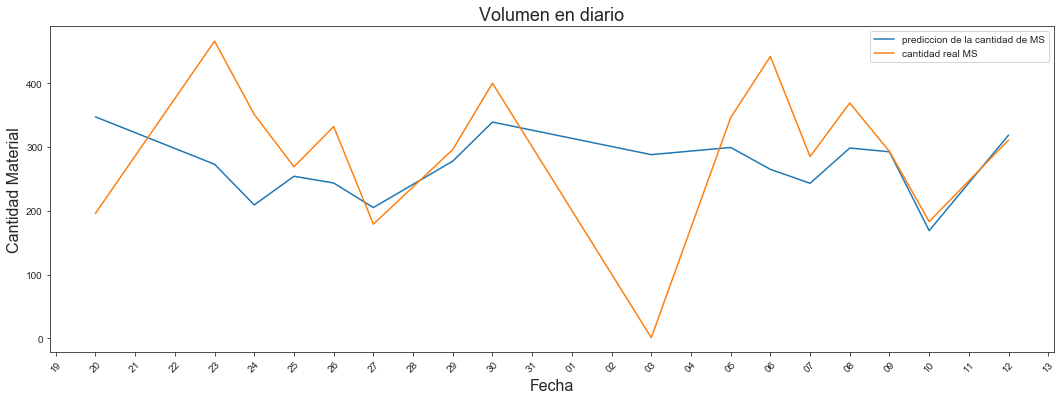

In [241]:
plot_comparative_time_series(df_cant_real_daily['Fecha Facturación'], df_real_prediccion['Forecast'], df_real_prediccion['Real'] ,'Volumen en diario', 'Fecha', 'Cantidad Material', 'prediccion de la cantidad de MS', 'cantidad real MS')


In [242]:
df_real_prediccion['APE'].median()

0.14965192683539108

In [243]:
df_real_prediccion['Real'].sum() - df_real_prediccion['Forecast'].sum()

396.32655073769365

In [244]:
(df_real_prediccion['Real'].sum() - df_real_prediccion['Forecast'].sum())/df_real_prediccion['Real'].sum()

0.08398528305524341

In [128]:
#guardo la RNR para futuros usos
regressor.save("RNR-MS-13.h5")

<h2> Ejecución de la predicción <h2/>

In [129]:
#cargo el regresor previamente entrenado
regressor = load_model('RNR-MS-13.h5')

In [245]:
#Organizo la informacion del calendario del forecast
fecha_inicio_forecast = '2021-04-23'
fecha_fin_forecast = '2021-05-31'

dataset_pred = pd.read_excel("../datos/DiasHabilesFuente.xlsx")
dataset_pred = dataset_pred[ (dataset_pred['Días_Operativos'] == 1) ]

dataset_pred['Fecha de entrega'] = pd.to_datetime(dataset_pred['Fecha de entrega'])
dataset_pred = dataset_pred[ (dataset_pred['Fecha de entrega'] >= fecha_inicio_forecast) & (dataset_pred['Fecha de entrega'] <= fecha_fin_forecast)]
fechas = dataset_pred.iloc[:, 3:4].values
dataset_pred = dataset_pred[['Dia_Semana', 'Dia_Semana','Semana_Relativa', 'Semanas_mes', 'Mes', 'Año']]
#tomo unicamente el array que me interasa del dataframe 
predict_set = dataset_pred.iloc[:, 0:7].values
predict_set_scaled = sc.transform(predict_set)

In [246]:
#obtenego los ultimos Timesteps dias, para iniciar la regresion
dataset = pd.read_excel("../datos/Base Acumulada.xlsx")
df = dataset[ (dataset['Nombre Material']!="SERVICIO FLETE MORTERO SECO") & (dataset['Nombre Material']!="Sobre Cargo Mortero") & (dataset['Nombre Material']!="Servicio de Descargue Mortero") & (dataset['Nombre Material']!="CEMEX EN SU BODEGA MORTERO") & (dataset['Sum of Cantidad Material'] > 0)]

#Dataset calendario logistico
calendario = pd.read_excel("../datos/DiasHabilesFuente.xlsx")
calendario['Fecha de entrega'] = pd.to_datetime(calendario['Fecha de entrega'])
calendario = calendario[ (calendario['Días_Operativos'] == 1) ]

#Agrupo la informacion por dia
df_cant_real_daily = dataset_test.groupby(['Fecha Facturación'])['Sum of Cantidad Material'].agg('sum').reset_index()

#Agrego informacion del calendario logistico
df_cant_real_daily = pd.merge(df_cant_real_daily, calendario[['Fecha de entrega', 'Dia_Semana','Semana_Relativa', 'Semanas_mes', 'Mes', 'Año']], how='inner', left_on='Fecha Facturación', right_on='Fecha de entrega' )
df_cant_real_daily = df_cant_real_daily.drop(['Fecha de entrega'], axis=1)

#tomo unicamente el array que me interasa del dataframe 
test_set = df_cant_real_daily.iloc[:, 1:7].values
cant_real = test_set
test_set_scaled = sc.transform(test_set)

#los inputs van a ser los ultimos Timesteps dias del training set, para predecir el primer dia 
inputs = test_set_scaled[len(test_set_scaled) - timesteps: ]
#inputs

In [247]:
for j in range (0, predict_set_scaled.shape[0] ):
    X_test = []
    X_test_material = []
    X_test_DiaSemana = []
    X_test_SemanaRelativa = []
    X_test_SemanaMes = []
    X_test_Mes = []
    X_test_Year = []

    for i in range(timesteps, inputs.shape[0]+1 ):

        #columna 0 -> Cantidad Material
        X_test_material.append( inputs[i-timesteps:i, 0])

        #columna 1 -> DiaSemana
        X_test_DiaSemana.append( inputs[i-timesteps:i, 1])

        #columna 2 -> SemanaRelativa
        X_test_SemanaRelativa.append( inputs[i-timesteps:i, 2])

        #columna 3 -> SemanaMes
        X_test_SemanaMes.append( inputs[i-timesteps:i, 3])

        #columna 4 -> Mes
        X_test_Mes.append( inputs[i-timesteps:i, 4])

        #columna 5 -> Year
        X_test_Year.append( inputs[i-timesteps:i, 5])


    #se convierten los array en objetos numpy    
    X_test_material = np.array( X_test_material)
    X_test_DiaSemana =  np.array(X_test_DiaSemana )
    X_test_SemanaRelativa = np.array( X_test_SemanaRelativa)
    X_test_SemanaMes = np.array(X_test_SemanaMes )
    X_test_Mes = np.array(X_test_Mes )
    X_test_Year = np.array( X_test_Year)

    #Se agrega una nueva dimension a las variables
    X_test_material = np.reshape(X_test_material, (X_test_material.shape[0], X_test_material.shape[1], 1 ))
    X_test_DiaSemana = np.reshape(X_test_DiaSemana, (X_test_DiaSemana.shape[0], X_test_DiaSemana.shape[1], 1 ))
    X_test_SemanaRelativa = np.reshape(X_test_SemanaRelativa, (X_test_SemanaRelativa.shape[0], X_test_SemanaRelativa.shape[1], 1 ))
    X_test_SemanaMes = np.reshape(X_test_SemanaMes, (X_test_SemanaMes.shape[0], X_test_SemanaMes.shape[1], 1 ))
    X_test_Mes = np.reshape(X_test_Mes, (X_test_Mes.shape[0], X_test_Mes.shape[1], 1 ))
    X_test_Year = np.reshape(X_test_Year, (X_test_Year.shape[0], X_test_Year.shape[1], 1 ))

    #se crea el la estructura de datos que se le va a pasar al regresor
    X_test = np.append(X_test_material, (X_test_DiaSemana), axis = 2 )
    X_test = np.append(X_test, (X_test_SemanaRelativa), axis = 2 )
    X_test = np.append(X_test, (X_test_SemanaMes), axis = 2 )
    X_test = np.append(X_test, (X_test_Mes), axis = 2 )
    X_test = np.append(X_test, (X_test_Year), axis = 2 )

    # por fin, ejecutar prediccion
    prediction = regressor.predict(X_test)

    #a la prediccion le agrego las demas variables predictoras
    prediction = np.append(prediction, (predict_set_scaled[:len(prediction), 1 : ]), axis=1 )

    inputs = test_set_scaled[len(test_set_scaled) - timesteps:]

    inputs = np.append(inputs, (prediction), axis=0 )
    
prediction = sc.inverse_transform(prediction)

In [248]:
df_forecast = pd.DataFrame({'Fecha':fechas[:, 0], 'Forecast':prediction[:, 0]})
df_forecast

,Fecha,Forecast
0,2021-04-23,332.578528
1,2021-04-24,292.425256
2,2021-04-26,225.661535
3,2021-04-27,210.747433
4,2021-04-28,320.903686
5,2021-04-29,332.969130
6,2021-04-30,312.719071
7,2021-05-03,199.870125
8,2021-05-04,276.320374
9,2021-05-05,339.379995


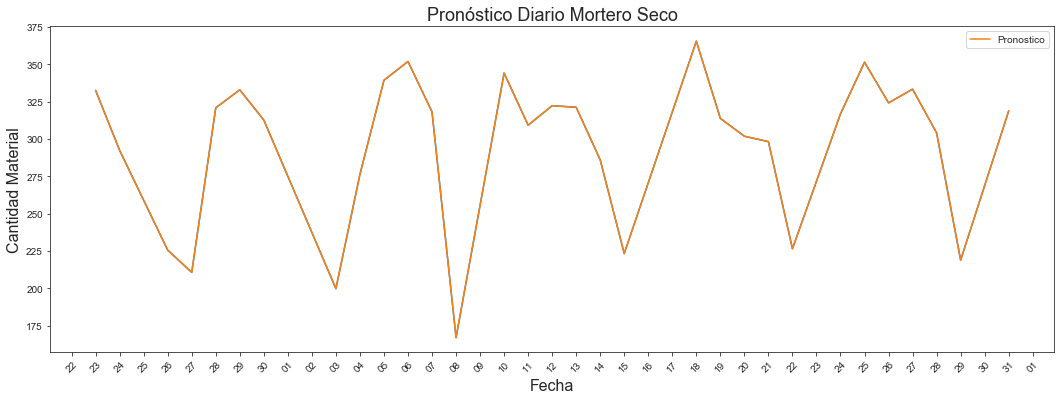

In [249]:
plot_comparative_time_series(df_forecast['Fecha'], df_forecast['Forecast'] ,  df_forecast['Forecast'] ,'Pronóstico Diario Mortero Seco', 'Fecha', 'Cantidad Material', '', 'Pronostico')


In [250]:
df_forecast['year_month']=df_forecast["Fecha"].dt.to_period('M')
final_result = df_forecast.groupby('year_month').sum()
final_result

,Forecast
year_month,
2021-04,2028.004640
2021-05,7133.361085


<h1>Desagregación Forecast</h1>

In [11]:
def tendencia( historia, unidad_desagregacion ):
    #Obtenemos Tendencia de cada centro
    promediDiarioSemanal = historia.groupby(['Año','Mes', unidad_desagregacion, 'Semana_Relativa'])['totalEntregado'].mean().reset_index()
    promediDiarioMensual = historia.groupby(['Año','Mes', unidad_desagregacion])['totalEntregado'].mean().reset_index()
    
    TendenciaSemanal = pd.merge(promediDiarioSemanal, promediDiarioMensual, how = 'inner', left_on=['Año', 'Mes', unidad_desagregacion], right_on = ['Año', 'Mes', unidad_desagregacion] )
    TendenciaSemanal['TendenciaSemana'] = TendenciaSemanal['totalEntregado_x']/TendenciaSemanal['totalEntregado_y']
    TendenciaSemanal = TendenciaSemanal.groupby([unidad_desagregacion, 'Semana_Relativa'])['TendenciaSemana'].mean().reset_index()
    return TendenciaSemanal 

def ciclicidad( historia, unidad_desagregacion ):
    #Obtenemos Ciclicidad de cada centro
    promediDiarioMensual = historia.groupby(['Año','Mes', unidad_desagregacion])['totalEntregado'].mean().reset_index()
    promedioDiarioDiaSemana = despachosSQL.groupby(['Año','Mes', unidad_desagregacion, 'Dia_Semana'])['totalEntregado'].mean().reset_index()
    CiclicidadDiaSemana = pd.merge(promedioDiarioDiaSemana, promediDiarioMensual, how = 'inner', left_on=['Año', 'Mes', unidad_desagregacion], right_on = ['Año', 'Mes', unidad_desagregacion] )
    CiclicidadDiaSemana['CiclicidadDiaSemana'] = CiclicidadDiaSemana['totalEntregado_x']/CiclicidadDiaSemana['totalEntregado_y']
    CiclicidadDiaSemana = CiclicidadDiaSemana.groupby([unidad_desagregacion, 'Dia_Semana'])['CiclicidadDiaSemana'].mean().reset_index()
    return CiclicidadDiaSemana

def generarDesagregacion( pais, despachosSQL, despachosSQL_historiaReciente, despachosSQL_absPlantas, absorcionEstadistica ,calendarioLogistico, volumenPais ):
    #Obtenemos Tendencia y ciclicidad de cada centro    
    TendenciaSemanal = tendencia(despachosSQL, 'Nombre Material') 
    CiclicidadDiaSemana = ciclicidad(despachosSQL, 'Nombre Material')
    
    
    TendenciaSemanal_historiaReciente = tendencia(despachosSQL_historiaReciente, 'Nombre Material') 
    TendenciaSemanal_historiaReciente.rename(columns={'Semana_Relativa':'Semana_Relativa2', 'TendenciaSemana': 'TendenciaSemana_inst'}, inplace = True)
    CiclicidadDiaSemana_historiaReciente = ciclicidad(despachosSQL_historiaReciente, 'Nombre Material')
    CiclicidadDiaSemana_historiaReciente.rename(columns={'Dia_Semana':'DiaSemana2', 'CiclicidadDiaSemana': 'CiclicidadDiaSemana_inst'},inplace = True)
    
    #SETUP DESAGREGACION
    
    #AbsorcionPlanta
    if absorcionEstadistica == True:  
        DesagregacionPronosticoPlanta = pd.DataFrame(despachosSQL_absPlantas.groupby(['Nombre Material'])['totalEntregado'].sum()).reset_index()
        DesagregacionPronosticoPlanta['totalPais'] = despachosSQL_absPlantas['totalEntregado'].sum()
        DesagregacionPronosticoPlanta['absorcionPlanta'] = DesagregacionPronosticoPlanta['totalEntregado'] / DesagregacionPronosticoPlanta['totalPais']
        DesagregacionPronosticoPlanta['M3ForecastPlanta'] = DesagregacionPronosticoPlanta['absorcionPlanta'] * volumenPais
        DesagregacionPronosticoPlanta = DesagregacionPronosticoPlanta.drop("totalEntregado", 1)
        DesagregacionPronosticoPlanta = DesagregacionPronosticoPlanta.drop("totalPais", 1)
        DesagregacionPronosticoPlanta = DesagregacionPronosticoPlanta.drop("absorcionPlanta", 1)
    
    else :
        #volPaisPlanta = pd.read_excel('../DatosAbsorcionPlantas/' + pais + '.xlsx')
        DesagregacionPronosticoPlanta = pd.read_excel('../DatosAbsorcionPlantas/' + pais + '.xlsx')
        
    
    
    #cross join tabla DesagregacionPronostico y calendario
    calendarioLogistico['key'] = 1
    DesagregacionPronosticoPlanta['key'] = 1
    DesagregacionPronosticoPlantaDia = pd.merge(calendarioLogistico, DesagregacionPronosticoPlanta, on = 'key').drop("key",1)
    #join con tendencia y ciclicidad anual
    DesagregacionPronosticoPlantaDia = pd.merge(DesagregacionPronosticoPlantaDia, TendenciaSemanal, how='left', left_on=['Nombre Material','Semana_Relativa'], right_on=['Nombre Material','Semana_Relativa'] ).fillna(1)
    DesagregacionPronosticoPlantaDia = pd.merge(DesagregacionPronosticoPlantaDia, CiclicidadDiaSemana, how='left', left_on=['Nombre Material','Dia_Semana'], right_on=['Nombre Material','Dia_Semana'] ).fillna(1)
    #join con tendencia y ciclicidad instantanea o mensual
    DesagregacionPronosticoPlantaDia = pd.merge(DesagregacionPronosticoPlantaDia, TendenciaSemanal_historiaReciente, how='left', left_on=['Nombre Material','Semana_Relativa'], right_on=['Nombre Material','Semana_Relativa2'] ).fillna(1)
    DesagregacionPronosticoPlantaDia = pd.merge(DesagregacionPronosticoPlantaDia, CiclicidadDiaSemana_historiaReciente, how='left', left_on=['Nombre Material','Dia_Semana'], right_on=['Nombre Material','DiaSemana2'] ).fillna(1)
    
    #quito columnas que no me interesan
    DesagregacionPronosticoPlantaDia = DesagregacionPronosticoPlantaDia.drop("Dia_Semana",1)
    DesagregacionPronosticoPlantaDia = DesagregacionPronosticoPlantaDia.drop("Semana_Relativa",1) 
    DesagregacionPronosticoPlantaDia = DesagregacionPronosticoPlantaDia.drop("DiaSemana2",1)
    DesagregacionPronosticoPlantaDia = DesagregacionPronosticoPlantaDia.drop("Semana_Relativa2",1) 
    #DesagregacionPronosticoPlantaDia = DesagregacionPronosticoPlantaDia.drop("absorcionPlanta",1) 
    
    
    #SETUP MATRIZ DE ITERACIONES
    DesagregacionPronosticoPlantaDia['M3Forecast'] = (DesagregacionPronosticoPlantaDia['Días_Operativos'] * (DesagregacionPronosticoPlantaDia['M3ForecastPlanta']/DesagregacionPronosticoPlantaDia['Total_Dias_Habiles_Mes'] ) * DesagregacionPronosticoPlantaDia['TendenciaSemana'] * DesagregacionPronosticoPlantaDia['CiclicidadDiaSemana'] * DesagregacionPronosticoPlantaDia['TendenciaSemana_inst'] * DesagregacionPronosticoPlantaDia['CiclicidadDiaSemana_inst'] ).astype(float)
    
    matrizPPTO_Resultado = pd.DataFrame(DesagregacionPronosticoPlantaDia.groupby('Nombre Material')['M3Forecast'].sum()).reset_index()
    matrizPPTO_Resultado = pd.merge(matrizPPTO_Resultado, DesagregacionPronosticoPlanta, on = 'Nombre Material' ).drop("key",1)
    matrizPPTO_Resultado['gap'] = matrizPPTO_Resultado['M3Forecast'] - matrizPPTO_Resultado['M3ForecastPlanta']
    matrizPPTO_Resultado['ResultadoIteracion'] = matrizPPTO_Resultado['M3Forecast']
    matrizPPTO_Resultado['M3Forecast'] = matrizPPTO_Resultado['M3ForecastPlanta'] - matrizPPTO_Resultado['gap']
    
    gapTotal = matrizPPTO_Resultado['gap'].abs().sum()
    
    while( gapTotal > 1 ):
        
        print('iteracion: ' + str(gapTotal) )
    
        for index, row in matrizPPTO_Resultado.iterrows():
            DesagregacionPronosticoPlantaDia.loc[DesagregacionPronosticoPlantaDia['Nombre Material'] == row['Nombre Material'], ['M3ForecastPlanta']] = row['M3Forecast']
            
        DesagregacionPronosticoPlantaDia['M3Forecast'] = (DesagregacionPronosticoPlantaDia['Días_Operativos'] * (DesagregacionPronosticoPlantaDia['M3ForecastPlanta']/DesagregacionPronosticoPlantaDia['Total_Dias_Habiles_Mes'] ) * DesagregacionPronosticoPlantaDia['TendenciaSemana'] * DesagregacionPronosticoPlantaDia['CiclicidadDiaSemana'] * DesagregacionPronosticoPlantaDia['TendenciaSemana_inst'] * DesagregacionPronosticoPlantaDia['CiclicidadDiaSemana_inst'] ).astype(float)
        
        matrizTemp = pd.DataFrame(DesagregacionPronosticoPlantaDia.groupby('Nombre Material')['M3Forecast'].sum()).reset_index()
        
        for index, row in matrizTemp.iterrows():
            matrizPPTO_Resultado.loc[matrizPPTO_Resultado['Nombre Material'] == row['Nombre Material'], ['ResultadoIteracion']] = row['M3Forecast']
        
        matrizPPTO_Resultado['gap'] = matrizPPTO_Resultado['ResultadoIteracion'] - matrizPPTO_Resultado['M3ForecastPlanta']
        matrizPPTO_Resultado['M3Forecast'] = matrizPPTO_Resultado['M3Forecast'] - matrizPPTO_Resultado['gap']
        
        gapTotal = matrizPPTO_Resultado['gap'].abs().sum()
        
    DesagregacionPronosticoPlantaDia = DesagregacionPronosticoPlantaDia.drop("M3ForecastPlanta",1)    
    
    return DesagregacionPronosticoPlantaDia

In [256]:
#PRINCIPAL

#años para entrenar las versiones
yearDesagregacion = 2021
mesDesagregacion = 5

#Targets
pais = 'Colombia'    
volPais = 7133
yearTarget = 2021
mesTarget = 5

inicioHistoria = datetime.datetime(2021, 1, 1) #'2013-05-01'
finHistoria = datetime.datetime.today() 

historiaAbsorcionPlanta = 30

In [257]:
#Dataset calendario logistico
calendarioLogistico = pd.read_excel("../datos/DiasHabilesFuente.xlsx")
calendarioLogistico['Fecha de entrega'] = pd.to_datetime(calendarioLogistico['Fecha de entrega'])
calendarioLogistico = calendarioLogistico[ (calendarioLogistico['Año'] == yearTarget) & (calendarioLogistico['Mes'] == mesTarget)]

In [258]:
#Agrupo la informacion por dia
despachosSQL = df.groupby(['Fecha Facturación','Nombre Material'])['Sum of Cantidad Material'].agg('sum').reset_index()

#Agrego informacion del calendario logistico
despachosSQL = pd.merge(despachosSQL, calendario[['Fecha de entrega', 'Dia_Semana','Semana_Relativa', 'Semanas_mes', 'Mes', 'Año']], how='inner', left_on='Fecha Facturación', right_on='Fecha de entrega' )
despachosSQL = despachosSQL.drop(['Fecha de entrega'], axis=1)
despachosSQL.rename(columns={"Fecha Facturación":"FechaEntrega", "Sum of Cantidad Material" : "totalEntregado"}, inplace=True) 


In [259]:
#-------Despacho absorcion --------------
despacho_Abs = despachosSQL.loc[ (despachosSQL['FechaEntrega']  >= datetime.datetime.today() - datetime.timedelta(historiaAbsorcionPlanta))].reset_index()

#determino cuantos años tengo de historia
deltaYears = finHistoria.year - inicioHistoria.year

inicio = datetime.datetime.today() - datetime.timedelta((deltaYears)* 365)
inicio = inicio - MonthBegin(1)
#el fin de la historia siempre va a ser el mes anterior al actual, para dejar los datos de este mes como testeo
fin = datetime.datetime.today() - datetime.timedelta(30)
fin = fin + MonthEnd(1)

#Historia largo plazao, filtro el despacho (solo la historia de cada mes ej, sept 2019, 2018, 2017...), voy aumentando historia anual en cada ciclo de i
despacho_anual_filtrados = despachosSQL.loc[ (despachosSQL['FechaEntrega'] >= inicio.strftime("%Y-%m-%d")) & 
                                       (despachosSQL['FechaEntrega'] <= fin.strftime("%Y-%m-%d")) &
                                       (despachosSQL['FechaEntrega'].dt.month == mesDesagregacion) 
                                       ].reset_index()


In [260]:
#Historia instantanea
inicio_menusal = datetime.datetime.today() - datetime.timedelta((6)* 30 )
inicio_menusal = inicio_menusal - MonthBegin(1)
despacho_mensual_filtrado =  despachosSQL.loc[ (despachosSQL['FechaEntrega'] >= inicio_menusal.strftime("%Y-%m-%d"))& 
                                   (despachosSQL['FechaEntrega'] <= fin.strftime("%Y-%m-%d"))
                                   ].reset_index()


In [261]:
temp = generarDesagregacion(pais, despacho_anual_filtrados, despacho_mensual_filtrado, despacho_Abs, True ,calendarioLogistico, volPais) 

iteracion: 259.43735620867386
iteracion: 14.648756273300148


In [262]:
writer = pd.ExcelWriter("../datos/Desagregacion_" + pais + "_" + pd.to_datetime("now").strftime("%Y%m%d%H%M%S") + ".xlsx", engine='xlsxwriter')
temp.to_excel( writer, sheet_name="Desagregacion" )
writer.save()